# Tutorial for Flavours of Physics Challenge 

In this notebook we'll try some algorithms from `hep_ml` package

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!wget https://www.dropbox.com/s/yxyw00os79cg19n/training.root?dl=0 -O tau_data/training.root
!wget https://www.dropbox.com/s/gfefr8036dmmbsr/check_agreement.root?dl=0 -O tau_data/check_agreement.root

## Data preparation

In [2]:
import pandas
import root_numpy

tau_data = pandas.DataFrame(root_numpy.root2array('tau_data/training.root'))
tau_labels = tau_data.signal.values
tau_data = tau_data.drop('signal', axis=1)

ds_data = pandas.DataFrame(root_numpy.root2array('tau_data/check_agreement.root'))
ds_labels = ds_data.signal.values
ds_weights = ds_data.weight.values
ds_data = ds_data.drop(['signal', 'weight'], axis=1)

In [3]:
from sklearn.cross_validation import train_test_split
train, test, train_labels, test_labels = train_test_split(tau_data, tau_labels, train_size=0.5, random_state=11)

# prepare ds data for reweighting 
ds_train, ds_test, ds_train_labels, ds_test_labels, ds_train_weight, ds_test_weight = \
    train_test_split(ds_data, ds_labels, ds_weights, train_size=0.5, random_state=11)

In [4]:
variables = list(set(train.columns) - {'SPDhits', 'production', 'mass', 'min_ANNmuon'})

# Reweigting

`hep_ml.reweight` contains methods to reweight distributions. Typically we use reweighting of Monte Carlo to fight drawbacks of simulation, though there are many applications.

In this example we reweight multidimensional distibutions in $D_s \to \phi \pi$ channel: original (Monte Carlo) and target (sPlot data), the aim is to find new weights for original distribution, such that these multidimensional distributions will coincide.

**Pay attention: equality of distibutions for each feature ≠ equality of multivariate dist**

In [5]:
from hep_ml.metrics_utils import ks_2samp_weighted

In [6]:
columns = ['FlightDistance', 'IP_p1p2', 'p2_IP', 'p1_IP']

original = ds_test[ds_test_labels == 1]
target = ds_test[ds_test_labels == 0]
target_weight = ds_test_weight[ds_test_labels == 0]

train_original = ds_train[ds_train_labels == 1]
train_target = ds_train[ds_train_labels == 0]
train_target_weight = ds_train_weight[ds_train_labels == 0]

original_weight = numpy.ones(len(original))
train_original_weight = numpy.ones(len(train_original))

## Defining supplementary function

To compare distributions with different reweighitngs

In [7]:
hist_settings = {'bins': 100, 'normed': True, 'alpha': 0.5}

def draw_distributions(original, target, w_original, w_target):
    plt.figure(figsize=[14, 8])
    for subplot_id, column in enumerate(columns, 1):
        xlim = numpy.percentile(numpy.hstack([target[column]]), [0.1, 99.])
        plt.subplot(2, 2, subplot_id)
        plt.hist(original[column].values, weights=w_original, range=xlim, label='MC', **hist_settings)
        plt.hist(target[column].values, weights=w_target, range=xlim, label='data', **hist_settings)
        plt.title(column), plt.legend(loc='best')
        ks_value = ks_2samp_weighted(original[column], target[column], weights1=w_original, weights2=w_target)
        print 'KS = {:2.5f}'.format(ks_value), ' over ', column

KS = 0.11084  over  FlightDistance
KS = 0.09482  over  IP_p1p2
KS = 0.10577  over  p2_IP
KS = 0.09148  over  p1_IP


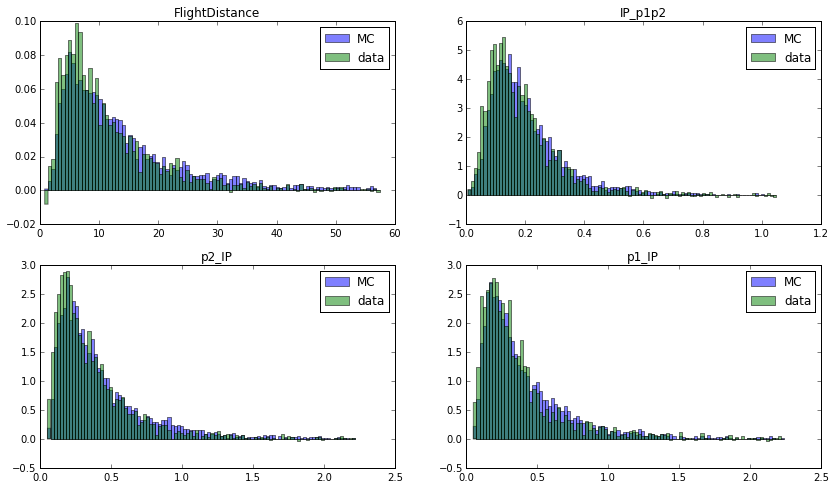

In [8]:
draw_distributions(train_original, train_target, train_original_weight, train_target_weight)

In [9]:
# pay attention, actually we have very few data
len(train_original), len(train_target)

(4090, 53297)

In [10]:
# original.shape

## Bins-based reweighting in $n$ dimensions
Typical way to reweight distributions is based on bins.

In [11]:
from hep_ml import reweight

bins_reweighter = reweight.BinsReweighter(n_bins=10, n_neighs=1.)
bins_reweighter.fit(train_original[columns], train_target[columns], train_original_weight, train_target_weight)

train_bins_weight = bins_reweighter.predict_weights(train_original[columns])
bins_weight = bins_reweighter.predict_weights(original[columns])

### on train

KS = 0.03512  over  FlightDistance
KS = 0.03851  over  IP_p1p2
KS = 0.03627  over  p2_IP
KS = 0.02950  over  p1_IP


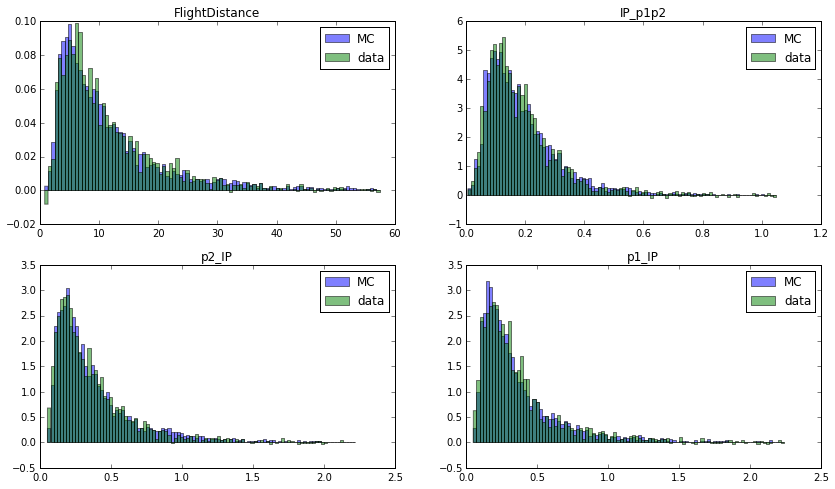

In [12]:
draw_distributions(train_original, train_target, train_bins_weight, train_target_weight)

### on test

KS = 0.03957  over  FlightDistance
KS = 0.06540  over  IP_p1p2
KS = 0.06424  over  p2_IP
KS = 0.03668  over  p1_IP


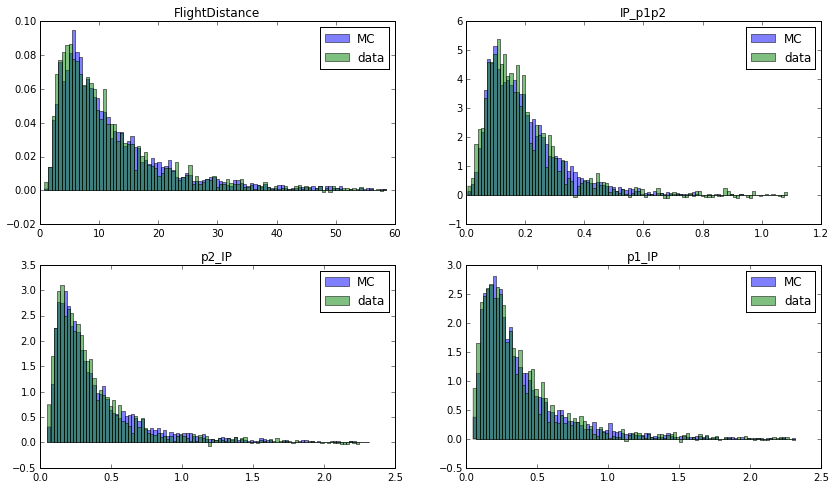

In [13]:
draw_distributions(original, target, bins_weight, target_weight)

## BDT Reweighter
This algorithm is inspired by gradient boosting and is able to fight curse of dimensionality. It uses decision trees and special loss functiion (ReweightLossFunction).
GBReweighter supports negative weights (to reweight MC to splotted real data).

In [14]:
reweighter = reweight.GBReweighter(n_estimators=30, learning_rate=0.1, max_depth=3, min_samples_leaf=2000)
reweighter.fit(train_original[columns], train_target[columns], train_original_weight, train_target_weight)

train_gb_weight = reweighter.predict_weights(train_original[columns])
gb_weight = reweighter.predict_weights(original[columns])

### on train

KS = 0.01756  over  FlightDistance
KS = 0.01829  over  IP_p1p2
KS = 0.01760  over  p2_IP
KS = 0.01876  over  p1_IP


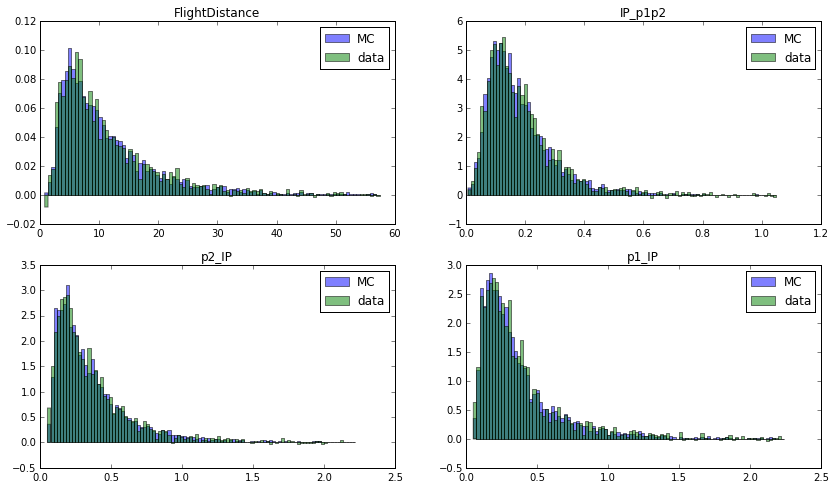

In [15]:
draw_distributions(train_original, train_target, train_gb_weight, train_target_weight)

### on test

KS = 0.06076  over  FlightDistance
KS = 0.03051  over  IP_p1p2
KS = 0.05085  over  p2_IP
KS = 0.04717  over  p1_IP


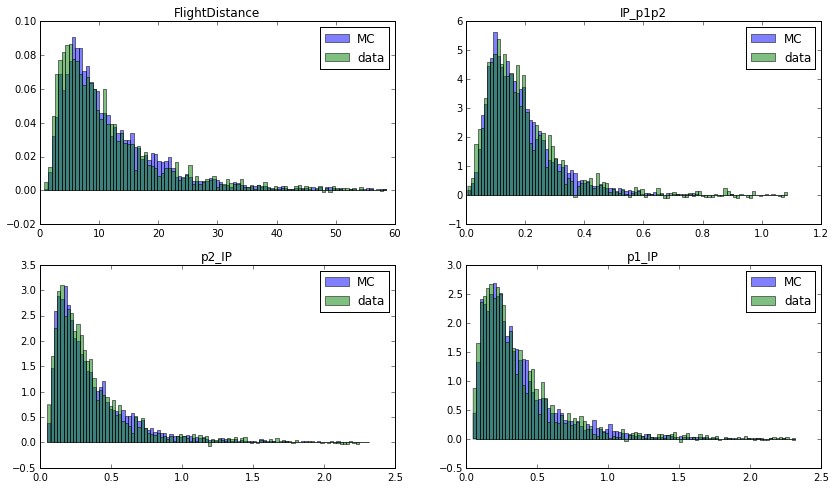

In [16]:
draw_distributions(original, target, gb_weight, target_weight)

# GB-discrimination
let's check how well the classifier is able to distinguish these distributions. ROC AUC is taken as measure of quality.
For this puprose we split data into train and test, then train a classifier do distinguish these distributions. If ROC AUC = 0.5 on test, distibutions are equal, if ROC AUC = 1.0, they are ideally separable.

0.592 original
0.555 bins
0.510 gb_weights


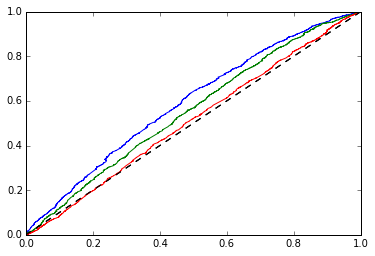

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

weights = {}
weights['original'] = (train_original_weight, original_weight)
weights['bins'] = (train_bins_weight, bins_weight)
weights['gb_weights'] = (train_gb_weight, gb_weight)

Xtrain = numpy.concatenate([train_original[columns], train_target[columns]])
Xtest = numpy.concatenate([original[columns], target[columns]])
Ytest = numpy.array([1] * len(original) + [0] * len(target))

for name, (Wtr, Wts) in weights.items():
    Wtrain = numpy.concatenate([Wtr / Wtr.sum() * train_target_weight.sum(), train_target_weight])
    Wtest = numpy.concatenate([Wts / Wts.sum() * target_weight.sum(), target_weight])
    Ytrain = numpy.array([1] * len(Wtr) + [0] * len(train_target_weight))
    Ytrain[Wtrain < 0] = abs(1 - Ytrain[Wtrain < 0])
    Wtrain = abs(Wtrain)
    
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=30, random_state=11).fit(
        Xtrain, Ytrain, sample_weight=Wtrain)
    auc = roc_auc_score(Ytest, clf.predict_proba(Xtest)[:, 1], sample_weight=Wtest)
    fpr, tpr, _ = roc_curve(Ytest, clf.predict_proba(Xtest)[:, 1], sample_weight=Wtest)
    plot(fpr, tpr, label=name)
    plot([0, 1], [0, 1], 'k--')
    xlim(0, 1), ylim(0, 1)
    print '{:1.3f}'.format(auc), name

# Boosting to Uniformity (use the mass during training)
In physical applications frequently we need to achieve uniformity of predictions along some features. For instance, when testing the existence of new particle, we need classifier to be uniform in background along the mass (otherwise one can get false discovery due to peaking background).

* uBoost
* gradient boosting with knn-Ada loss (UGB+knnAda)
* gradient boosting with FlatnessLoss (UGB+FlatnessLoss)

In [18]:
from hep_ml.uboost import uBoostClassifier
from hep_ml.gradientboosting import UGradientBoostingClassifier, KnnFlatnessLossFunction
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.metaml import ClassifiersFactory
from rep.estimators import SklearnClassifier

In [19]:
from evaluation import roc_auc_truncated

In [20]:
n_estimators = 100
train_features = variables
uniform_features = ['mass']

In [21]:
classifiers = ClassifiersFactory()

base_ada = GradientBoostingClassifier(max_depth=4, n_estimators=n_estimators, learning_rate=0.1)
classifiers['AdaBoost'] = SklearnClassifier(base_ada, features=train_features)

uboost_clf = uBoostClassifier(uniform_features=uniform_features, uniform_label=0,
                              base_estimator=DecisionTreeClassifier(max_depth=4), 
                              n_estimators=n_estimators, train_features=train_features, 
                              efficiency_steps=12, n_threads=4)
classifiers['uBoost'] = SklearnClassifier(uboost_clf)

flatnessloss = KnnFlatnessLossFunction(uniform_features, fl_coefficient=5., power=2., uniform_label=0)
ugbFL = UGradientBoostingClassifier(loss=flatnessloss, max_depth=4, n_estimators=n_estimators, 
                                    learning_rate=0.1, train_features=train_features)
classifiers['UGB+FL'] = SklearnClassifier(ugbFL)


classifiers.fit(train, train_labels, parallel_profile='threads-3')
pass

model AdaBoost     was trained in 48.54 seconds
model uBoost       was trained in 243.53 seconds
model UGB+FL       was trained in 132.06 seconds
Totally spent 243.53 seconds on training


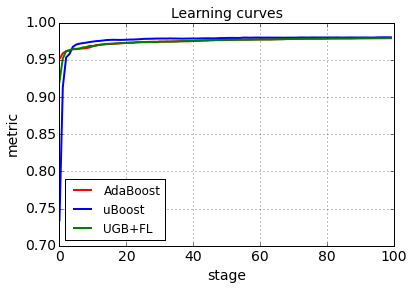

In [22]:
report = classifiers.test_on(test, test_labels)

# ylim(0.88, 0.94)
report.learning_curve(roc_auc_truncated, steps=1)

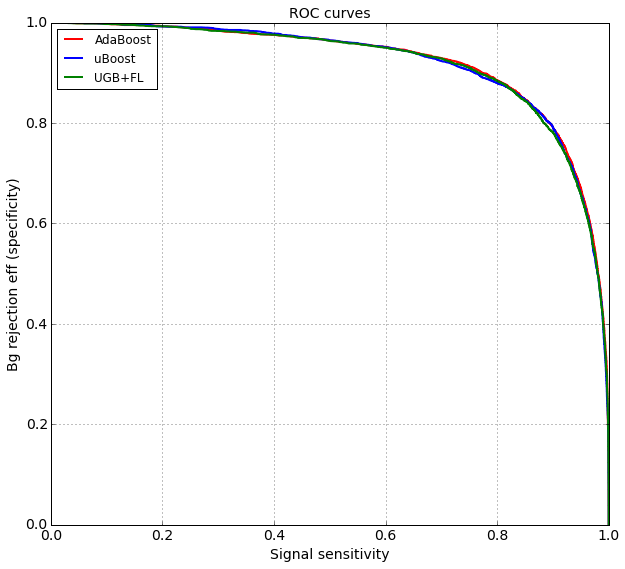

In [23]:
report.roc().plot(new_plot=True, figsize=[10, 9])

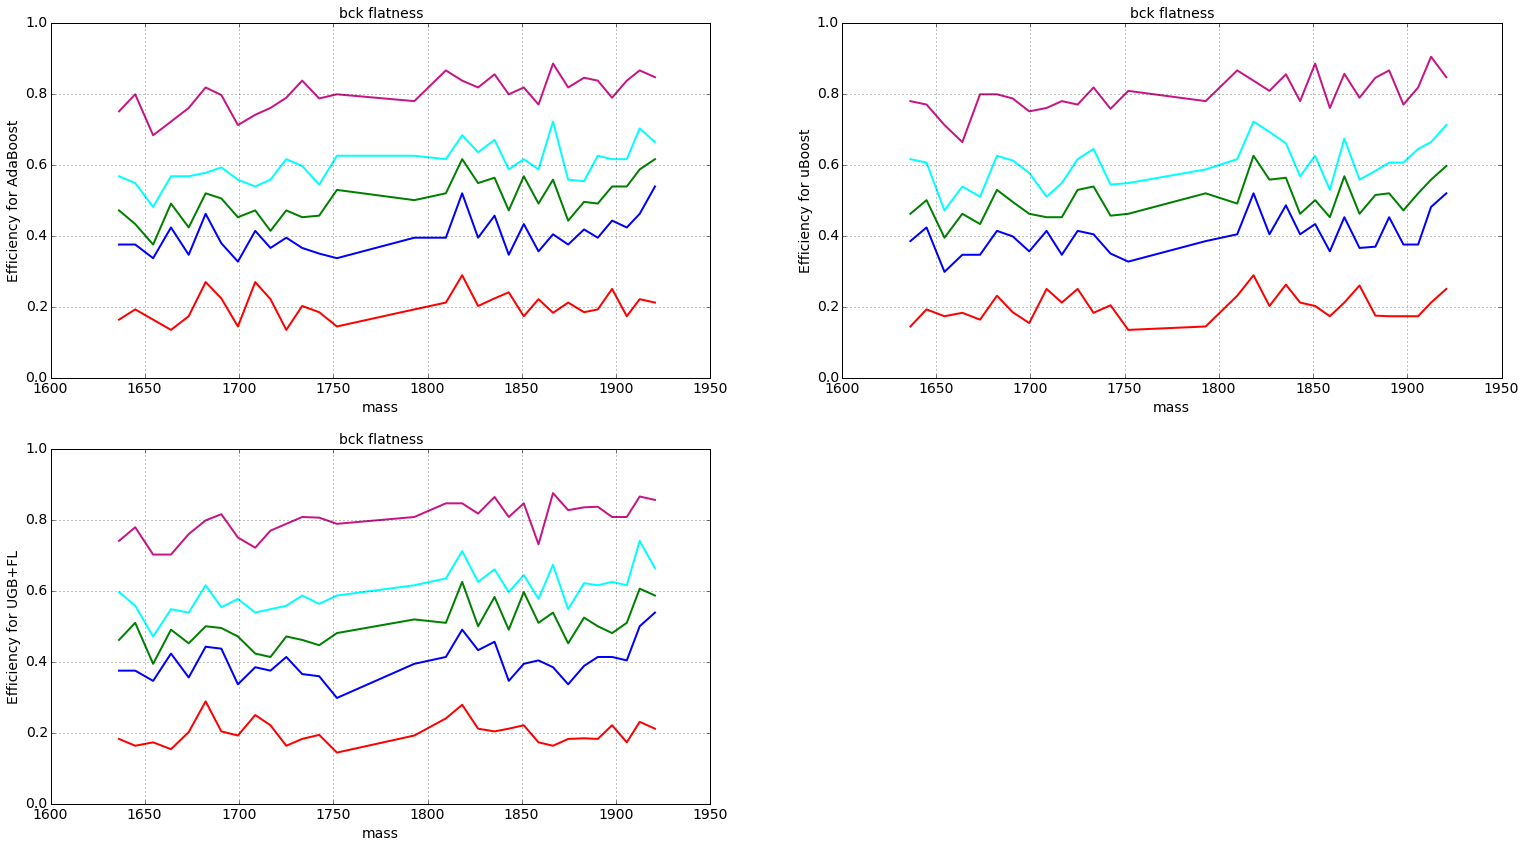

In [24]:
report.efficiencies(['mass'], ignored_sideband=0.1, labels_dict={0: 'bck'}).plot(show_legend=False)

In [26]:
from evaluation import compute_cvm
class CVMmetric_metric:
    def fit(self, data, labels, sample_weight=None):
        self.bck_mass = data.loc[labels == 0, 'mass']
        
    def __call__(self, y_true, y_pred, sample_weight=None):
        return compute_cvm(y_pred[y_true == 0, 1], self.bck_mass)
                       
                       
report.compute_metric(CVMmetric_metric())

OrderedDict([('AdaBoost', 0.0014389740616666553),
             ('uBoost', 0.0012985608774969222),
             ('UGB+FL', 0.0013254435032385959)])